# Sown To Grow DS takehome
by Agnes He
Date: Nov 4, 2023

## Guide 
 	
Sown To Grow (STG) is a K12 education technology platform that empowers schools to improve student social, emotional, and academic health through an easy and engaging reflection and feedback process. In a short weekly routine, students check-in emotionally and reflect on the strategies that are working best for them (or new ones to try). They start with a focus on emotional well-being and expand to academic goal-setting over time. Teachers, principals, and counselors understand real-time student emotions with AI-driven insights, and proactively support student needs.

The data for this exercise is a snapshot from emotional well being module wherein every week educators give students a prompt to respond to. Students respond to the prompt with an emoji (reference below) followed by a reflection. This snapshot contains reflections that mention bullying. Sometimes students share if they or someone they know are being bullied in the present or have been bullied recently which warrants reflection being flagged as alert and email being sent out to the educators to checkin with the student. These reflections have is_concerning flagged as yes. Other times students are talking about bullying as a general topic. These reflections have is_concerning flag set to no. 

**Task: Can you attempt to solve this problem by applying a combination of Natural Language Processing, Rules based approach and Machine Learning techniques to classify concerning vs not concerning reflections? We recommend following CRISP DM framework if you need help with breaking down the solution into different parts. Do this in a notebook (jupyter notebook, google colab etc) wherein you can add notes about different decisions you're making along the process and share your rationale behind those decisions.**

Selected candidates will be invited for a round of technical interview to talk through your solution.

Guidelines for solutioning:
1. Spend some time in the problem space, take your time to scan and understand the data before you start solutioning.
2. Cleaning up and preprocessing text data can be a huge project in itself, feel free to spend more time on that piece and less/no time on the rules/classification piece if that's where your strength and interest lie - part of the reason behind this exercise is to understand where your strengths and interests lie.
3. Perform this task in a notebook (jupyter notebook, google colab etc) wherein you can add notes about different decisions you're making along the process and your rationale behind those decisions. We understand that part of the problem may seem open ended, feel free to make your assumptions and note them as you go.
4. NLP/ML/DS problems can feel open ended and endless, and you can always perfect a solution. This exercise is not a test for a perfect solution but how do you optimize for your time and efforts. Do your best and spend at most 2 hours trying to solve the problem or parts of the problem. 
5. Take time to choose your final metric of evaluation, and explain why you are making that choice. If the final results don't look promising, elicit what are some of the things you would need or try next to solve this problem more accurately.

### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

from wordcloud import WordCloud, STOPWORDS
import string
import scipy.stats as stats
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
# nltk.download('wordnet')
# nltk.download('punkt')
import xgboost as xgb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# EDA

In [2]:
# Load the dataset
df = pd.read_csv('data.csv')
df.head()

,prompt,reflection,emoji,is_concerning
0,"In 2-3 sentences, write about a time when you ...",When I was in third grade someone would bully ...,Neutral,no
1,"Tell me more about your week. What went well, ...",well this week was pretty hard for me you see ...,Very Sad,yes
2,What do you like most about school? What do yo...,Bullying,Very Happy,no
3,If you were to write a rulebook for social med...,dont cyberbully,Happy,no
4,What do you like most about school? What do yo...,bullys,Neutral,no


In [3]:
# Sanity check: size, null values, dtype etc. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   prompt         525 non-null    object
 1   reflection     525 non-null    object
 2   emoji          525 non-null    object
 3   is_concerning  525 non-null    object
dtypes: object(4)
memory usage: 16.5+ KB


In [4]:
# Count unique values in each column
df.nunique()

prompt            11
reflection       489
emoji              5
is_concerning      2
dtype: int64

<Axes: >

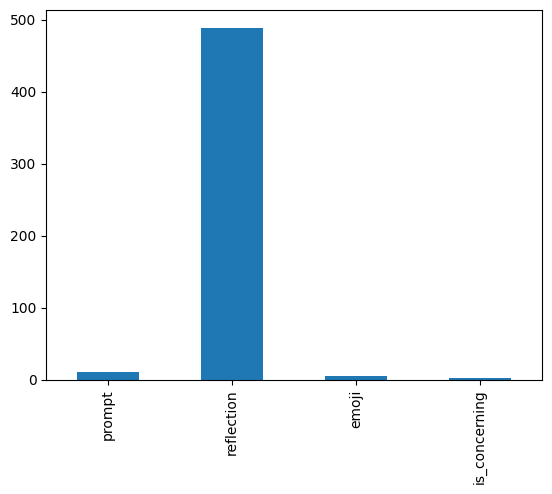

In [5]:
# Plot the count
df.nunique().plot.bar()

## Feature Analysis
### prompt

In [6]:
# Get the unique value of the prompt feature. 
df['prompt'].unique()

array(['In 2-3 sentences, write about a time when you chose not to stand up or “speak out”. What can you do differently next time?',
       "Tell me more about your week. What went well, and what's been hard?",
       'What do you like most about school? What do you not like about school?',
       'If you were to write a rulebook for social media, what rules would you write for how people should treat each other online? And why?',
       'Tell me more about your week. What strategies helped you, and what can you try next week?',
       'How would you respond to someone who is being “picked on”? What would you say? What would you do?',
       'What is something that you can do to stop bullying?',
       'How do you know when someone else is worried or upset? How might you help them?',
       'Tell me about a time when a classmate or friend tried to negatively influence you or encouraged you to behave badly. How did you handle it?',
       'Did you have a conflict with anyone this week? 

<Axes: >

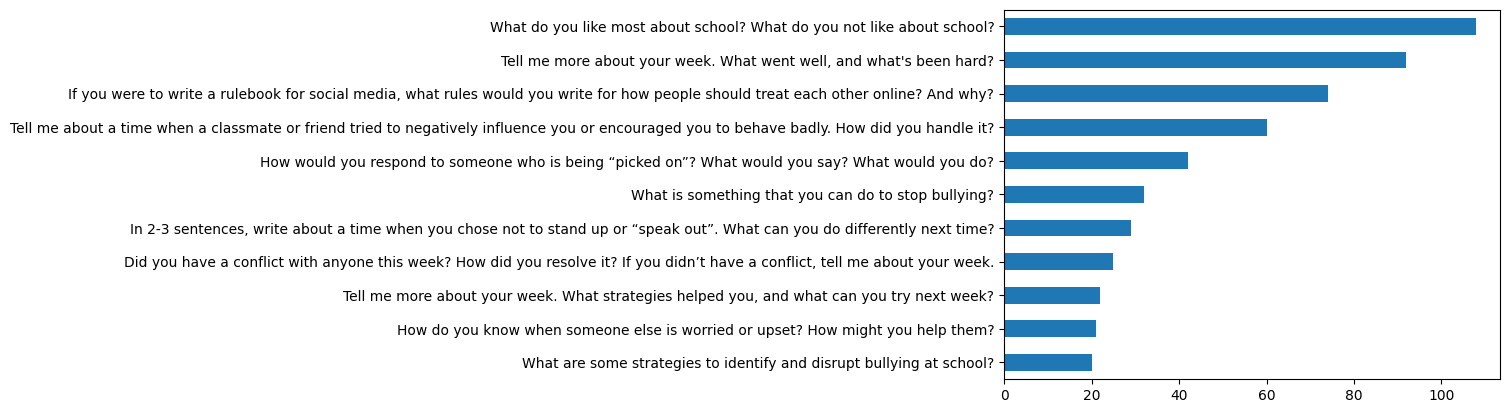

In [7]:
# Plot the number of samples for each prompt, sorted in descending order.
df['prompt'].value_counts().sort_values().plot.barh()

In [8]:
# Get the concerning/non-concerning ratio for each prompt.
pd.crosstab(df['prompt'], df['is_concerning'], normalize='index').sort_values(by='yes', ascending=False)

is_concerning,no,yes
prompt,,
"Tell me more about your week. What went well, and what's been hard?",0.228261,0.771739
"Did you have a conflict with anyone this week? How did you resolve it? If you didn’t have a conflict, tell me about your week.",0.400000,0.600000
"Tell me more about your week. What strategies helped you, and what can you try next week?",0.409091,0.590909
What do you like most about school? What do you not like about school?,0.611111,0.388889
Tell me about a time when a classmate or friend tried to negatively influence you or encouraged you to behave badly. How did you handle it?,0.866667,0.133333
How do you know when someone else is worried or upset? How might you help them?,0.904762,0.095238
What are some strategies to identify and disrupt bullying at school?,0.950000,0.050000
What is something that you can do to stop bullying?,0.968750,0.031250
How would you respond to someone who is being “picked on”? What would you say? What would you do?,0.976190,0.023810


There are 11 prompt questions in total, some questions have more reflections than others, the top three questions have the most reflections are: 
* 'What do you like most about school? What do you not like about school?'
* 'Tell me more about your week. What went well, and what's been hard?'.
* If you were to write a rulebook for social media, what rules would you write for how people should treat each other online? And why?
  
Some questions have more concerning reflections rate than others, the top three questions are:
* Tell me more about your week. What went well, and what's been hard?
* Did you have a conflict with anyone this week? How did you resolve it? If you didn’t have a conflict, tell me about your week.
* Tell me more about your week. What strategies helped you, and what can you try next week?

Clearly, the most reflected prompts don't necessarily have a high concerning ratio, e.g. for prompt 'If you were to write a rulebook for social media, what rules would you write for how people should treat each other online? And why?', although there are more then 70 reflections, none of the reflections are considered as concerning. 

Questions with high concerning rate (the top three) are all questions asking about students' feeling about the passing week (things are already happend or are happening), whereas for questions with the lowest concerning rate, the prompt is more about how does a student deal with a imaginary situation (things have not happened yet). Therefore, prompt types could be a relevant feature, the _prompt_ feature could be dealt with two possible approaches:
1. Treated as categorical data: <br>
   Use one-hot encoding to transform prompts into vectors. Fast and easy to start with.
2. Pair with reflections and treated as text data:<br>
   In this case, there will be lots of duplicated tokens in the text corpus, which will create a larger vector space for training. The semantic meaning of the prompts doesn't seems to be very critical for this dataset.

For this practice, I will choose the 1st aproach.  

In [9]:
# Create nomial encoding for prompts
prompt_encode = dict(zip(df['prompt'].unique(), range(11)))
print(prompt_encode)

{'In 2-3 sentences, write about a time when you chose not to stand up or “speak out”. What can you do differently next time?': 0, "Tell me more about your week. What went well, and what's been hard?": 1, 'What do you like most about school? What do you not like about school?': 2, 'If you were to write a rulebook for social media, what rules would you write for how people should treat each other online? And why?': 3, 'Tell me more about your week. What strategies helped you, and what can you try next week?': 4, 'How would you respond to someone who is being “picked on”? What would you say? What would you do?': 5, 'What is something that you can do to stop bullying?': 6, 'How do you know when someone else is worried or upset? How might you help them?': 7, 'Tell me about a time when a classmate or friend tried to negatively influence you or encouraged you to behave badly. How did you handle it?': 8, 'Did you have a conflict with anyone this week? How did you resolve it? If you didn’t have

In [10]:
# Plot a stacked bar chart for number of concerning/non-concering samples for each prompt
temp = df.groupby(['prompt','is_concerning']).size().reset_index(level=[0, 1], name='count')
temp['encode_pmpt'] = temp['prompt'].map(dict(zip(df['prompt'].unique(), range(11))))#[str(i) for i in range(11)]
fig = px.bar(temp, y="encode_pmpt", x="count", color="is_concerning", orientation='h')
fig.show()

![](img/prompt.png)

### emoji

In [11]:
# Get the number of concerning/non-concerning for each emoji.
pd.crosstab(df['emoji'], df['is_concerning'])

is_concerning,no,yes
emoji,,
Happy,60,10
Neutral,200,71
Sad,26,29
Very Happy,67,8
Very Sad,18,36


In [12]:
# Get the ratio of concerning/non-concerning for each emoji.
pd.crosstab(df['emoji'], df['is_concerning'], normalize='index').sort_values(by='yes', ascending=False)

is_concerning,no,yes
emoji,,
Very Sad,0.333333,0.666667
Sad,0.472727,0.527273
Neutral,0.738007,0.261993
Happy,0.857143,0.142857
Very Happy,0.893333,0.106667


The _emoji_ feature is an ordinal feature contains 5 levels of emotions: We can encode the emojis from 0 to 4: the most negative emotion (Very Sad) as 4 and the most positive emotion (Very Happy) as 0, to represent the natural ranking. We can also observe a clear positive relationship between encoded emoji and concerning rate. (Note: The relationship will be inverse if we encode the emoji in an inverse order).

In [13]:
emoji_encode = {'Very Happy': 0, 'Happy':1, 'Neutral':2, 'Sad': 3, 'Very Sad':4}
temp = pd.crosstab(df['emoji'].map(emoji_encode), df['is_concerning'], normalize='index').reset_index()
fig = px.line(temp, x="emoji", y="yes")
fig.show()

![](img/line.png)

In [14]:
# Count number of samples for each emoji
df['emoji'].value_counts()

Neutral       271
Very Happy     75
Happy          70
Sad            55
Very Sad       54
Name: emoji, dtype: int64

In [15]:
# Plot the stacked bar chart
temp = df.groupby(['emoji','is_concerning']).size().reset_index(level=[0, 1], name='count')
fig = px.bar(temp, x="emoji", y="count", color="is_concerning")
fig.show()

![](img/emoji.png)

### reflection 

In [16]:
df['reflection']

0      When I was in third grade someone would bully ...
1      well this week was pretty hard for me you see ...
2                                               Bullying
3                                        dont cyberbully
4                                                 bullys
                             ...                        
520    Monday ,Tuesday, and Wednesday were good days ...
521    None. They never influenced me, they just bull...
522    i could of stand up when i saw a small kid get...
523    I like to have fun I don’t like to get bullied...
524    the only think i like about school is reses an...
Name: reflection, Length: 525, dtype: object

In [17]:
df[df['is_concerning']=='yes']['reflection'].sample(10)

110    wat i like school adout you can play and hav f...
84     I’ve been doing ok this week, I’ve had to deal...
443    My week was ok because one person was bullying...
178    people bully alot but the wings and hot sauce ...
405    I like to read at school. I don't like math, o...
434    i feel so sick but my mom wont let me stay hom...
42     Today a kid in my class bulled me and it reall...
112    I like the teachers they are helpful and the t...
464    Ramzi Keeps bulling me and I handled it by tel...
264    What went well was I went to Topgolf with Xavi...
Name: reflection, dtype: object

In [18]:
## Count how many words in a reflection
def count_reflection_words(reflection):
    '''Count the number of words in a reflection.'''
    return len(reflection.split())

df['reflection_length'] = df['reflection'].apply(lambda x: count_reflection_words(x))

<Axes: >

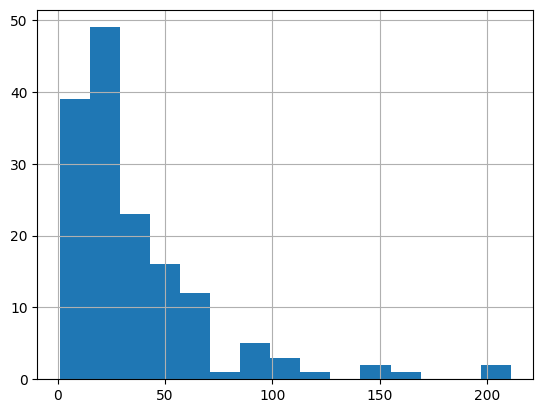

In [19]:
df[df['is_concerning']=='yes']['reflection_length'].hist(bins=15)

<Axes: >

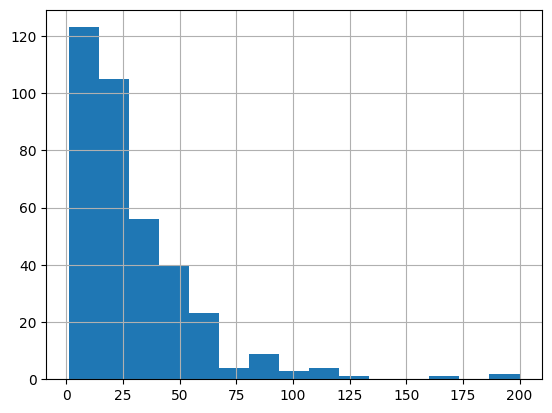

In [20]:
df[df['is_concerning']=='no']['reflection_length'].hist(bins=15)

In [21]:
df.groupby('is_concerning')['reflection_length'].mean()

is_concerning
no     29.180593
yes    36.006494
Name: reflection_length, dtype: float64

In [22]:
df.groupby('is_concerning')['reflection_length'].std()

is_concerning
no     27.166001
yes    35.590536
Name: reflection_length, dtype: float64

In [23]:
# Plot the boxplot of token_length for concerning/non-concerning reflections
fig = px.box(df, x='is_concerning', y="reflection_length", height=800, width=600)
fig.show()

![](img/box.png)

The distribution of token_length appears to be slightly different between concerning and non-concerning reflections. The mean of concerning reflections is 36, with a standard deviation of 35.59, whereas the non-concerning reflections have a mean of 29, and a standard deviation of 27. This feature maybe useful in model training.

To visualize the most frequent words in reflection, plot the wordcloud. 

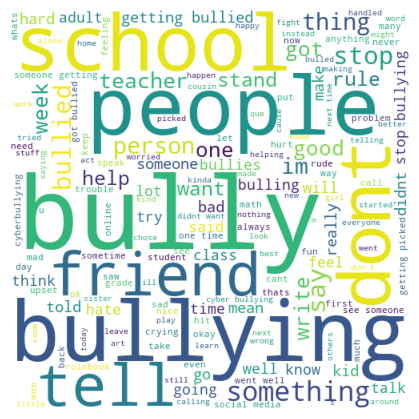

In [24]:
# Plot word cloud from dataframe
def plot_wc(df):
    reflection_words = ''
    stopwords = set(STOPWORDS)
    
    for val in df:
         
        # typecaste each val to string
        val = str(val).translate(str.maketrans('', '', string.punctuation))
     
        # split the value
        tokens = val.split()
         
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        reflection_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 500, height = 500,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(reflection_words)
     
    # plot the WordCloud image                       
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
     
    plt.show()

plot_wc(df['reflection'])

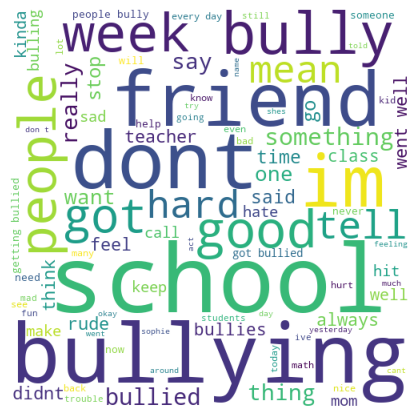

In [25]:
# Plot wordcloud for concerning reflections
plot_wc(df[df['is_concerning']=='yes']['reflection'])

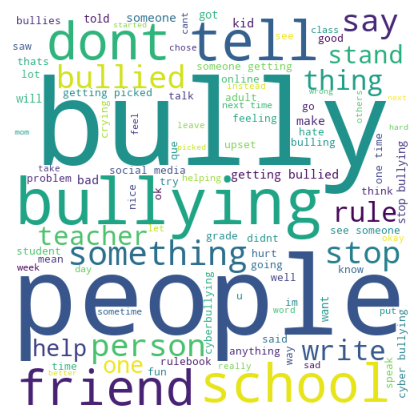

In [26]:
# Plot wordcloud for non-concerning reflections
plot_wc(df[df['is_concerning']=='no']['reflection'])

In [27]:
# Get the top n words in a corpus and plot
def top_n_words(df,column,n, title):
    ''' Get the top n words in a corpus and plot.
    
    Args:
        df: Dataframe containing the documents
        column: corresponding column name containing the documents in the DataFrame
        n: top n words
        title: title of the bar plot.
    '''
    # remove punctuation
    corpus = [str(text).translate(str.maketrans('', '', string.punctuation)) for text in df[column]]
    
    # Tokenize the text and lemmatize the tokens
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(' '.join(corpus))
    lemma = [wnl.lemmatize(t, pos='v') for t in tokens]
    
    # Count word frequency and get the frequency dataframe for plotting
    cv = CountVectorizer(stop_words='english')
    count_freq = cv.fit_transform(lemma).sum(axis=0)
    bow = cv.get_feature_names_out()
    freq_df = pd.DataFrame()
    freq_df['word']=bow
    freq_df['count']=count_freq.tolist()[0]
    freq_df = freq_df.sort_values(by='count', ascending=False)

    # Plot top n words in horizontal barplot
    fig = px.bar(freq_df[0:n], x='count', y='word', orientation='h')
    fig.update_layout(title=title, yaxis=dict(autorange="reversed"))
    fig.show()

In [28]:
top_n_words(df,'reflection', 20, 'Overall top 20 words')

![](img/overall_top_20.png)

In [29]:
# Plot the top 20 words for concerning reflections
top_n_words(df[df['is_concerning']=='yes'],'reflection', 20, 'top 20 words - concerning reflections')

![](img/pos_top_20.png)

In [30]:
# Plot the top 20 words for non-concerning reflections
top_n_words(df[df['is_concerning']=='no'],'reflection', 20, 'top 20 words - non-concerning reflections')

![](img/neg_top_20.png)

**Concerning Reflection Top Words:**
The words in this category, such as "bully," "like," "school," "don't," "people," and "im," seem to highlight reflections associated with negative or concerning experiences, particularly those related to instances of bullying or adverse social interactions within a school or peer environment.

* **Bully**: Indicates a direct reference to the experience of being bullied or witnessing bullying behavior.
* **Like, School, People**: Common words suggesting the context might revolve around interpersonal relationships within a school setting.
* **Don't, Im, Say, Tell, Friends**: Words that could be associated with advice, communication, or emotional expression about difficult situations.
These words collectively express sentiments associated with negative experiences, conflict, and potentially distressing situations, commonly encountered in a school environment.

**Non-Concerning Reflection Top Words:**
The words in this category, such as "bully," "people," "tell," "like," "stop," "say," and "school," depict reflections that might aim to address or prevent negative experiences.

* **Bully, People, Tell**: Shared with the concerning reflection list, hinting at the persistent concern about bullying and the involvement of individuals.
* **Like, Stop, Say, School**: Words that suggest a desire for change, advocating for action, communication, and creating a safer or more positive environment.
* **Person, Write, Help, Time, Make, Rule**: Words related to taking action, seeking assistance, and making changes in response to the identified concerns.
  
This set appears to reflect a proactive or solution-oriented approach, acknowledging the issues, seeking support, and emphasizing actions to prevent or address negative situations, especially bullying.

Both lists share common words such as "bully," "people," "tell," "like," "school," and "say," indicating a consistent focus on issues related to bullying, communication, and the school environment. However, the categorization suggests a distinction in the approach—concerning reflections highlight more on personal experiences and emotional reactions, while non-concerning reflections express a more action-oriented, problem-solving mindset, aiming to address and prevent negative situations.

At a machine learning perspective, this analysis suggest the word frequency, word occurance in the two classes could be useful as training features in the model. Two approaches can be used for this type of feature: TFIDF, or language models like BERT. 

In this practice, I'll use the TFIDF method. TFIDF measures the significance of a term within a document corpus. It considers not only the frequency of a term in a document but also how unique or important that term is within the entire corpus. The cons of TFIDF is it does not consider word order or the context in which words are used. It treats each term independently, disregarding the sequence of words and their semantics, which may limit its understanding of the text. But conbining TFIDF and _emoji_ feature, will give us a sense of the sentiment of the reflection.

Although BERT is better at learn the sentiment of the reflections, the modeling process will involve combining BERT embeddings and categorical features embenddings, which is more time consuming and requires more computing power.  

### is_concerning

In [31]:
df['is_concerning'].value_counts()/len(df)

no     0.706667
yes    0.293333
Name: is_concerning, dtype: float64

The positive class is less than 30% which create a mild **imbalance** dataset. Two common approaches for handling imbalanced datasets are resampling and assigning class weights.

1. Resampling:
* Resampling techniques involve either oversampling the minority class or undersampling the majority class. Oversampling duplicates instances of the minority class, while undersampling involves reducing the number of instances in the majority class.
* This helps in balancing the class distribution, which can prevent the model from being biased towards the majority class.
2. Assigning Class Weights:
* Assigning class weights is another effective technique. It involves adjusting the importance of each class during the training phase. This is commonly used in machine learning algorithms by assigning higher weights to the minority class and lower weights to the majority class.
* By giving more weight to the minority class, the model pays more attention to these instances during training, ensuring it doesn't overlook them.

Since the given dataset contains about 500 rows, choosing to assign class weights might be preferred for several reasons:

1. Preservation of Original Data: In a relatively small dataset (500 rows), altering the data through resampling might result in a loss of potentially valuable information present in the original instances.

2. Maintaining Dataset Size: Resampling might lead to a substantial change in the dataset size if done aggressively, potentially affecting the overall representativeness of the data.

3. Effective Utilization of Limited Data: By assigning class weights, you're not altering the dataset but instead instructing the model to pay more attention to the existing instances of the minority class. This allows you to make the most of the limited amount of available data.

4. Potential for Model Generalization: Class weights help in addressing the imbalance issue without significantly altering the dataset. This method might assist the model in generalizing better to unseen data, especially considering the limited sample size.

# Preprocess
### Ordinal Encoding

In [32]:
# Encode the emoji feature by discussed above.
emoji_encode = {'Very Happy': 0, 'Happy':1, 'Neutral':2, 'Sad': 3, 'Very Sad':4}
df['emoji_encode'] = df['emoji'].map(emoji_encode)
prompt_encode = dict(zip(df['prompt'].unique(), range(11)))
df['prompt_encode'] = df['prompt'].map(prompt_encode)
df

,prompt,reflection,emoji,is_concerning,reflection_length,emoji_encode,prompt_encode
0,"In 2-3 sentences, write about a time when you ...",When I was in third grade someone would bully ...,Neutral,no,35,2,0
1,"Tell me more about your week. What went well, ...",well this week was pretty hard for me you see ...,Very Sad,yes,48,4,1
2,What do you like most about school? What do yo...,Bullying,Very Happy,no,1,0,2
3,If you were to write a rulebook for social med...,dont cyberbully,Happy,no,2,1,3
4,What do you like most about school? What do yo...,bullys,Neutral,no,1,2,2
...,...,...,...,...,...,...,...
520,"Tell me more about your week. What went well, ...","Monday ,Tuesday, and Wednesday were good days ...",Sad,yes,40,3,1
521,Tell me about a time when a classmate or frien...,"None. They never influenced me, they just bull...",Happy,no,10,1,8
522,"In 2-3 sentences, write about a time when you ...",i could of stand up when i saw a small kid get...,Neutral,no,17,2,0
523,What do you like most about school? What do yo...,I like to have fun I don’t like to get bullied...,Neutral,no,14,2,2


### Dummy variables

In [33]:
# Create dummy variables for the prompt feature
X = pd.concat([df, pd.get_dummies(df['prompt_encode'],prefix='prompt')], axis=1).drop(['prompt', 'emoji', 'is_concerning'], axis=1)
X

,reflection,reflection_length,emoji_encode,prompt_encode,prompt_0,prompt_1,prompt_2,prompt_3,prompt_4,prompt_5,prompt_6,prompt_7,prompt_8,prompt_9,prompt_10
0,When I was in third grade someone would bully ...,35,2,0,1,0,0,0,0,0,0,0,0,0,0
1,well this week was pretty hard for me you see ...,48,4,1,0,1,0,0,0,0,0,0,0,0,0
2,Bullying,1,0,2,0,0,1,0,0,0,0,0,0,0,0
3,dont cyberbully,2,1,3,0,0,0,1,0,0,0,0,0,0,0
4,bullys,1,2,2,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,"Monday ,Tuesday, and Wednesday were good days ...",40,3,1,0,1,0,0,0,0,0,0,0,0,0
521,"None. They never influenced me, they just bull...",10,1,8,0,0,0,0,0,0,0,0,1,0,0
522,i could of stand up when i saw a small kid get...,17,2,0,1,0,0,0,0,0,0,0,0,0,0
523,I like to have fun I don’t like to get bullied...,14,2,2,0,0,1,0,0,0,0,0,0,0,0


### TFIDF

In [34]:
# Remove punctuation
corpus = [str(text).translate(str.maketrans('', '', string.punctuation)) for text in df['reflection']]

# Apply lemmatization
wnl = WordNetLemmatizer()
tokens = [word_tokenize(str) for str in corpus]
new_corpus = []
for row in tokens:
    lemma = [wnl.lemmatize(t, pos='v') for t in row]
    new_corpus.append(' '.join(lemma))

In [35]:
# Transform the reflection to TFIDF and save it into dataframe format
tv = TfidfVectorizer(min_df=0.01, max_df=0.9)
tfidf = tv.fit_transform(new_corpus)
tfidf_df = pd.DataFrame(tfidf.todense(), columns=tv.get_feature_names_out())
tfidf_df

,about,act,adult,after,again,all,alone,also,always,an,...,wont,word,work,worry,would,write,wrong,year,you,your
0,0.000000,0.0,0.259162,0.0,0.0,0.0,0.0,0.23787,0.0,0.0,...,0.0,0.0,0.0,0.0,0.168341,0.00000,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.134099,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.22491,0.0,0.0,0.000000,0.0
521,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0
522,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0
523,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0


# Modeling

## Dataset split

In [36]:
y = (df['is_concerning']=='yes').astype(int)

In [37]:
# Concatenating all features for training set
X = pd.concat([tfidf_df, X.drop('reflection', axis=1)], axis=1)
X

,about,act,adult,after,again,all,alone,also,always,an,...,prompt_1,prompt_2,prompt_3,prompt_4,prompt_5,prompt_6,prompt_7,prompt_8,prompt_9,prompt_10
0,0.000000,0.0,0.259162,0.0,0.0,0.0,0.0,0.23787,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
521,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
522,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
523,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [38]:
# Split the dataset as a dev set and a test set (hold out set)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [39]:
# Futher split the dev set to a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.125, random_state=42, stratify=y_dev)

### Base line (Random Forest)
The first model to build is a Random Forest Classifier. RFC is a robust and versatile ensemble learning method that operates by constructing multiple decision trees during training and outputs the class that is the mode of the classes predicted by individual trees. It's a great starting point for our problem.

In [40]:
rfc = RandomForestClassifier(n_estimators=300, class_weight='balanced', max_depth=10, bootstrap=False)
rfc.fit(X_train, y_train)
y_hat = rfc.predict(X_val)
print(classification_report(y_val, y_hat))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        37
           1       0.71      0.75      0.73        16

    accuracy                           0.83        53
   macro avg       0.80      0.81      0.80        53
weighted avg       0.83      0.83      0.83        53



In [41]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        74
           1       0.71      0.71      0.71        31

    accuracy                           0.83       105
   macro avg       0.79      0.79      0.79       105
weighted avg       0.83      0.83      0.83       105



### XGBoost
XGBoost can handle imbalanced datasets better than Random Forest due to its boosting approach, which emphasizes correcting misclassifications, hence giving more weight to minority classes. While Random Forest can handle imbalanced data, it might not adapt as effectively as XGBoost due to the absence of boosting mechanisms. Also, XGBoost offers a wide range of hyperparameters to tune, allowing more flexibility for optimizing the model's performance. Hence, for this problem, I will train and optimize a XGBoost model.

In [42]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

xgbc = xgb.XGBClassifier(objective="binary:logistic", random_state=42, max_depth=3, n_estimators=500)
xgbc.fit(X_train, y_train, sample_weight=classes_weights)
y_hat = xgbc.predict(X_val)
print(classification_report(y_val, y_hat))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        37
           1       0.62      0.62      0.62        16

    accuracy                           0.77        53
   macro avg       0.73      0.73      0.73        53
weighted avg       0.77      0.77      0.77        53



In [43]:
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        74
           1       0.73      0.61      0.67        31

    accuracy                           0.82       105
   macro avg       0.79      0.76      0.77       105
weighted avg       0.81      0.82      0.81       105



## Hyperparameter tuning

In [44]:
# Define grid search space
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 300
    }

In [102]:
def hyperparameter_tuning(space):
    '''Grid search function using hyperopt and xgboost.'''
    model = xgb.XGBClassifier(n_estimators=int(space['n_estimators']), 
                              max_depth=int(space['max_depth']), 
                              gamma = space['gamma'],  
                              min_child_weight=space['min_child_weight'], 
                              colsample_bytree=space['colsample_bytree'],   
                             )
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
        )
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], sample_weight=classes_weights,
              verbose=False)

    y_pred = model.predict(X_val)
    
    score = roc_auc_score(y_val, y_pred)
    print ("SCORE:", score)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning, 
            space=space, algo=tpe.suggest, 
            max_evals=150, 
            trials=trials)
# Print the best params (best loss)
print(best)

SCORE:                                                                                                                      
0.8008771929824562                                                                                                          
SCORE:                                                                                                                      
0.8342105263157895                                                                                                          
SCORE:                                                                                                                      
0.880701754385965                                                                                                           
SCORE:                                                                                                                      
0.8210526315789474                                                                                                          


In [115]:
# Retrain the best model based on the best hyperparameter
best_model = xgb.XGBClassifier(colsample_bytree=0.893160559487327, 
                               gamma=5.059780348584796, 
                               max_depth=13, 
                               min_child_weight=3.0,  
                               reg_lambda=0.582041181603186,
                               n_estimators=300)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_dev
    )

best_model.fit(X_dev, y_dev, sample_weight=classes_weights,)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.893160559487327, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5.059780348584796,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=3.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluation
Identifying concerning reflections early can lead to timely intervention and support for students experiencing distress, potentially preventing further negative outcomes. Given the significance of detecting concerning reflections, minimizing false negatives is critical. False negatives occur when the model incorrectly predicts a non-concerning reflection as non-concerning. This can be detrimental in scenarios where a real concern might be overlooked. Therefore, **recall is the key metrics**. 

**Recall (also known as sensitivity)** is essential because it measures the model's ability to correctly identify all actual positive cases, in this case, concerning reflections. Maximizing recall helps minimize false negatives, ensuring that as many concerning reflections as possible are correctly identified. 

While recall is crucial, **F1 Score, precision, and AUROC** provide a more comprehensive evaluation of the model's performance, considering both false positives and false negatives. A well-balanced model should achieve high recall without significantly sacrificing precision, ensuring that concerning reflections are accurately identified while maintaining a low rate of false alarms.

In [117]:
y_hat = best_model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81        73
           1       0.58      0.78      0.67        32

    accuracy                           0.76       105
   macro avg       0.73      0.77      0.74       105
weighted avg       0.79      0.76      0.77       105



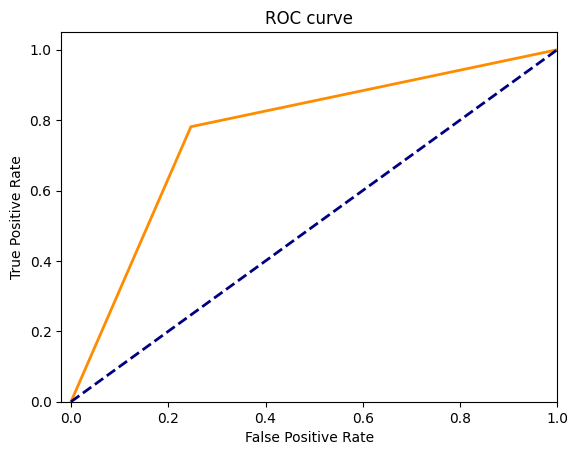

In [123]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_hat)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Discussion
The final model achieved an recall of 78% for this practice. There are still lots of optimization methods to be tried to improve the score. Some possible approaches are:
* Collect more data: Increasing the amount of data can benefit model performance. It provides a more comprehensive and diverse set of examples for the model to learn from, potentially capturing a wider range of patterns and nuances.

* Hyperparameter tuning (max_df, min_df in TF-IDF): Adjusting parameters in the TF-IDF (Term Frequency-Inverse Document Frequency) matrix, such as max_df (maximum document frequency) and min_df (minimum document frequency), could affect the model's feature representation. These parameters control the inclusion or exclusion of terms based on their frequency in the corpus. Tuning these can help in refining the features used for modeling.

* Using language models like BERT for text data embedding: BERT, a powerful language model, can create contextual embeddings for text data. However, it can't directly embed non-textual features like emojis or prompts. One approach to leverage BERT is by concatenating various features (prompt, emoji, reflection) into a single document. BERT can then generate embeddings for this combined document corpus, allowing the model to learn more complex relationships among different types of data.

* Feature selection based on a Random Forest model: Random Forest models can assist in identifying feature importance. Selecting the most crucial features determined by a Random Forest model and using a reduced set of features for training the final model can be beneficial. This process can help mitigate overfitting, reduce noise, and enhance the model's ability to generalize better to new data.

Each of these approaches has its strengths:

* Data Collection: Offers a broader scope for the model to learn diverse patterns.
* Hyperparameter Tuning: Fine-tunes the representation of text features, potentially improving the model's understanding of the data.
* BERT for Text Data Embedding: Integrates different types of data into a cohesive format, leveraging BERT's contextual understanding.
* Feature Selection: Focuses the model on the most relevant information, reducing overfitting and improving generalization. <br>

Implementing these strategies and iterating through them systematically can help in further optimizing the model's performance, potentially leading to a higher recall score. 